In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import probflow as pf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model

In [2]:
# Import historical yahoo finance dat
df = pd.read_csv('sp500_data.csv')

# Display the first few rows of the data
print(df.head())

         Date        ^GSPC
0  01/10/1999  1282.810059
1  04/10/1999  1304.599976
2  05/10/1999  1301.349976
3  06/10/1999  1325.400024
4  07/10/1999  1317.640015


In [3]:
# Load data and clean column names
df.columns = df.columns.str.strip()

# Ensure the index is a proper datetime format
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors="coerce") 

# Convert S&P 500 data to numeric, handle missing values
df["^GSPC"] = pd.to_numeric(df["^GSPC"], errors="coerce")
df.dropna(subset=["^GSPC"], inplace=True)

# Compute log returns and simple returns
df['Log Return'] = np.log(df['^GSPC'] / df['^GSPC'].shift(1))
df.dropna(inplace=True)  # Remove NaNs from first row

# Extract log returns as a Pandas Series (keeps original index)
log_returns = df['Log Return']

In [4]:
# Compute rolling mean and squared deviations for volatility
N = 21
rolling_mean = log_returns.rolling(window=N).mean()
squared_deviations = (log_returns - rolling_mean) ** 2
volatility = np.sqrt(squared_deviations.rolling(window=N).sum() / (N - 1))

In [5]:
# Drop the first 2*N-1 observations to remove NaNs
log_returns_dropped = log_returns.iloc[2*N-1:] 
volatility_dropped = volatility.iloc[2*N-1:]

log_returns_2d = log_returns_dropped.to_numpy().reshape(-1, 1)
volatility_2d = volatility_dropped.to_numpy().reshape(-1, 1)

In [6]:
# Combine data into a DataFrame
data = pd.DataFrame(
    np.hstack([log_returns_2d, volatility_2d]),
    columns=["Log_Returns", "Volatility"],
    index=log_returns_dropped.index  # Set the index after dropping
)
data = data.drop(df.index[-1])
data = data.loc["1999-12-14":]
print(data)

            Log_Returns  Volatility
Date                               
1999-12-14    -0.008551    0.008945
1999-12-15     0.007215    0.008948
1999-12-16     0.003849    0.008557
1999-12-17     0.001585    0.008134
1999-12-20    -0.002071    0.008059
...                 ...         ...
2024-12-23     0.007261    0.008165
2024-12-24     0.010982    0.008477
2024-12-26    -0.000406    0.008472
2024-12-27    -0.011117    0.008756
2024-12-30    -0.010760    0.008965

[6301 rows x 2 columns]


In [7]:
# Import t+1 predictions from SV model
df_sv = pd.read_csv('sv_predictions_1day.csv')
# Display the first few rows of the data
print(df_sv.head())

  Training_Start Training_End Prediction_Date  SV_Volatility
0     1997-02-04   1999-02-03      1999-02-04       0.011067
1     1997-02-05   1999-02-04      1999-02-05       0.010734
2     1997-02-06   1999-02-05      1999-02-08       0.012045
3     1997-02-07   1999-02-08      1999-02-09       0.011578
4     1997-02-10   1999-02-09      1999-02-10       0.010769


In [8]:
# Convert 'Prediction_Start' to datetime
df_sv['Training_End'] = pd.to_datetime(df_sv['Training_End'])

# Set 'Prediction_Start' as the index
df_sv.set_index('Training_End', inplace=True)

In [9]:
print(df_sv.head())

             Training_Start Prediction_Date  SV_Volatility
Training_End                                              
1999-02-03       1997-02-04      1999-02-04       0.011067
1999-02-04       1997-02-05      1999-02-05       0.010734
1999-02-05       1997-02-06      1999-02-08       0.012045
1999-02-08       1997-02-07      1999-02-09       0.011578
1999-02-09       1997-02-10      1999-02-10       0.010769


In [10]:
# Reshapes the SV array into a 2D column vector
sv_predictions=df_sv['SV_Volatility']
sv_predictions_2d = sv_predictions.to_numpy().reshape(-1, 1)

In [11]:
# Perform merge on the 'Date' and 'Prediction_Start'
merged_data = pd.merge_asof(data, df_sv, left_index=True, right_index=True, direction='forward')
merged_data.drop(columns=['Training_Start', 'Prediction_Date'], inplace=True)
print(merged_data)

            Log_Returns  Volatility  SV_Volatility
Date                                              
1999-12-14    -0.008551    0.008945       0.009355
1999-12-15     0.007215    0.008948       0.009436
1999-12-16     0.003849    0.008557       0.009260
1999-12-17     0.001585    0.008134       0.009083
1999-12-20    -0.002071    0.008059       0.008656
...                 ...         ...            ...
2024-12-23     0.007261    0.008165       0.009003
2024-12-24     0.010982    0.008477       0.008722
2024-12-26    -0.000406    0.008472       0.008790
2024-12-27    -0.011117    0.008756       0.008329
2024-12-30    -0.010760    0.008965       0.008535

[6301 rows x 3 columns]


In [12]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Scale values on each window and store the scalers
def minmax_scaling_per_window(window):
    scaler = MinMaxScaler(feature_range=(1e-11, 1)) 
    scaled_window = scaler.fit_transform(window)
    return pd.DataFrame(scaled_window, columns=window.columns, index=window.index), scaler

In [13]:
def walk_forward_validation(data, train_size, validation_size, test_size, lookback, target_col_index):
    prepared_data = []

    # Loop through the dataset with sliding windows
    for start in range(0, len(data) - train_size - validation_size - test_size, test_size):

        train_ws = data.iloc[start:start + train_size]
        validation_ws = data.iloc[start + train_size: start + train_size + validation_size]
        test_ws = data.iloc[start + train_size + validation_size: start + train_size + validation_size + test_size]

        # Combine train and validation windows for scaling
        train_val_ws = pd.concat([train_ws, validation_ws])
        train_val_ws_scaled, scaler = minmax_scaling_per_window(train_val_ws)
        test_ws_scaled, scaler_test = minmax_scaling_per_window(test_ws)

        def generate_sequences(window, lookback, target_col_index):
            X, y, date_indices = [], [], []
            for i in range(lookback, len(window)):
                X.append(window.iloc[i - lookback:i].values)  # Lookback sequence
                y.append(window.iloc[i, target_col_index])  # Target value
                date_indices.append(window.index[i])  # Store corresponding date
            return np.array(X), np.array(y), date_indices
        
        # Split scaled train_val window back into train and validation sets
        train_ws_scaled = train_val_ws_scaled.iloc[:len(train_ws)]
        validation_ws_scaled = train_val_ws_scaled.iloc[len(train_ws):]
        
        # Generate sequences for train, validation, and test sets
        X_train_ws, y_train_ws, train_dates = generate_sequences(train_ws_scaled, lookback, target_col_index)
        X_val_ws, y_val_ws, val_dates = generate_sequences(validation_ws_scaled, lookback, target_col_index)
        X_test_ws, y_test_ws, test_dates = generate_sequences(test_ws_scaled, lookback, target_col_index)

        prepared_data.append({
            "X_train_ws": X_train_ws,
            "y_train_ws": y_train_ws,
            "X_val_ws": X_val_ws,
            "y_val_ws": y_val_ws,
            "X_test_ws": X_test_ws,
            "y_test_ws": y_test_ws,
            "scaler_test": scaler_test,  # Store the test scaler
            "original_test_ws": test_ws,  # Store original test data
            "test_dates": test_dates  # Store test set date index
        })

    return prepared_data


# Call the function with parameters
prepared_data = walk_forward_validation(
    merged_data, 
    train_size=252*11, 
    test_size=252*1, 
    lookback=21, 
    validation_size=252*3, 
    target_col_index=1
)

first_window = prepared_data[0]
print("\nTest Window (test_ws) of the First Window:")
print(first_window['original_test_ws'].head())
print(f"\nTest Window Start Date: {first_window['original_test_ws'].index[0]}")
print(f"Test Window End Date: {first_window['original_test_ws'].index[-1]}")
print(f"Test Window Length: {len(first_window['original_test_ws'])} days")
print("\nFirst few prediction dates:")
print(first_window['test_dates'][:5])


Test Window (test_ws) of the First Window:
            Log_Returns  Volatility  SV_Volatility
Date                                              
2013-12-23     0.005304    0.005912       0.006985
2013-12-24     0.002912    0.005879       0.006818
2013-12-26     0.004734    0.005912       0.006519
2013-12-27    -0.000337    0.005916       0.006500
2013-12-30    -0.000179    0.005911       0.006182

Test Window Start Date: 2013-12-23 00:00:00
Test Window End Date: 2014-12-22 00:00:00
Test Window Length: 252 days

First few prediction dates:
[Timestamp('2014-01-24 00:00:00'), Timestamp('2014-01-27 00:00:00'), Timestamp('2014-01-28 00:00:00'), Timestamp('2014-01-29 00:00:00'), Timestamp('2014-01-30 00:00:00')]


In [14]:
# Initialize variables to track the lowest and largest volatility values
min_volatility = float('inf')
max_volatility = float('-inf')

# Loop through the prepared_data to find the min and max volatility
for data in prepared_data:
    # Flatten the X and y arrays and combine them
    all_volatilities = np.concatenate([data['y_train_ws'], data['y_val_ws'], data['y_test_ws']])

    # Update min and max volatility
    min_volatility = min(min_volatility, np.min(all_volatilities))
    max_volatility = max(max_volatility, np.max(all_volatilities))

# Print the results
print(f"Lowest volatility value: {min_volatility}")
print(f"Largest volatility value: {max_volatility}")

Lowest volatility value: 1.000000082740371e-11
Largest volatility value: 1.0000000000000002


In [15]:
first_window = prepared_data[0]  

X_train_ws = first_window["X_train_ws"]
y_train_ws = first_window["y_train_ws"]
X_val_ws = first_window["X_val_ws"]
y_val_ws = first_window["y_val_ws"]
X_test_ws = first_window["X_test_ws"]
y_test_ws = first_window["y_test_ws"]

print("First Window Data Shapes:")
print("X_train_ws shape:", X_train_ws.shape)
print("y_train_ws shape:", y_train_ws.shape)
print("X_val_ws shape:", X_val_ws.shape)
print("y_val_ws shape:", y_val_ws.shape)
print("X_test_ws shape:", X_test_ws.shape)
print("y_test_ws shape:", y_test_ws.shape)

First Window Data Shapes:
X_train_ws shape: (2751, 21, 3)
y_train_ws shape: (2751,)
X_val_ws shape: (735, 21, 3)
y_val_ws shape: (735,)
X_test_ws shape: (231, 21, 3)
y_test_ws shape: (231,)


In [16]:
contains_zero = any((batch["y_test_ws"] == 0).any() for batch in prepared_data)
print("Contains zero in any test set:", contains_zero)

zero_count = sum((batch["y_test_ws"] == 0).sum() for batch in prepared_data)
print("Total number of zeros in test sets:", zero_count)

zero_indices = [i for i, batch in enumerate(prepared_data) if (batch["y_test_ws"] == 0).any()]
print("Test set indices containing zeros:", zero_indices)

total_y_test_values = sum(len(batch["y_test_ws"]) for batch in prepared_data)
zero_ratio = zero_count / total_y_test_values if total_y_test_values > 0 else 0
print(f"Proportion of zeros across all test sets: {zero_ratio:.2%}")

Contains zero in any test set: False
Total number of zeros in test sets: 0
Test set indices containing zeros: []
Proportion of zeros across all test sets: 0.00%


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
!pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def tune_model(hp, input_shape):
    model = Sequential()

    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_lstm_layers):
        units = hp.Choice(f'lstm_units_{i+1}', values=[32, 64, 128])
        activation = hp.Choice(f'lstm_activation_{i+1}', values=['tanh', 'relu', 'sigmoid'])
        
        return_sequences = True if i < num_lstm_layers - 1 else False
        
        if i == 0:
            model.add(LSTM(units=units, activation=activation, return_sequences=return_sequences,
                           recurrent_dropout=hp.Float(f"lstm_recurrent_dropout_{i+1}", min_value=0.0, max_value=0.2, step=0.05),
                           input_shape=input_shape))
        else:
            model.add(LSTM(units=units, activation=activation, return_sequences=return_sequences,
                           recurrent_dropout=hp.Float(f"lstm_recurrent_dropout_{i+1}", min_value=0.0, max_value=0.2, step=0.05)))

        if hp.Boolean("dropout"):
            dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.05)  
            model.add(Dropout(rate=dropout_rate))

        # Fixed number of dense layers
        for i in range(3):
         dense_units = hp.Choice(f'dense_units_{i+1}', values=[32, 64, 128])
         dense_activation = hp.Choice(f'dense_activation_{i+1}', values=['tanh', 'relu', 'sigmoid'])
         model.add(Dense(units=dense_units, activation=dense_activation))


    model.add(Dense(1)) 

    learning_rate = hp.Choice("lr", values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2]) 
    loss_function = hp.Choice("loss_function", ["mean_squared_error", "mean_absolute_error"])  

    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss=loss_function,  
        metrics=["mean_squared_error"],  
    )

    return model

In [19]:
import os
import json
from tensorflow.keras.callbacks import Callback, EarlyStopping
import numpy as np
from keras_tuner import RandomSearch

class LastLossCallback(Callback):
    def __init__(self):
        super().__init__()
        self.last_val_loss = None

    def on_train_end(self, logs=None):
        if logs:
            self.last_val_loss = logs.get("val_loss")

    def get_last_loss(self):
        return self.last_val_loss if self.last_val_loss is not None else float("inf")

def save_avg_val_loss(directory, project_name, avg_val_loss):
    """Saves the avg validation loss to a JSON file."""
    file_path = os.path.join(directory, f"{project_name}_avg_val_loss.json")
    with open(file_path, "w") as f:
        json.dump({"avg_val_loss": avg_val_loss}, f)

def load_avg_val_loss(directory, project_name):
    """Loads the avg validation loss if it exists."""
    file_path = os.path.join(directory, f"{project_name}_avg_val_loss.json")
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return json.load(f).get("avg_val_loss", None)
    return None

def lstm_tune(window_data, window_index, tune_model):
    X_train, y_train = window_data["X_train_ws"], window_data["y_train_ws"]
    X_val, y_val = window_data["X_val_ws"], window_data["y_val_ws"]
    input_shape = X_train.shape[1:]

    project_name = f"lstm_tuned_window_{window_index + 1}"
    tuner_dir = "3dense"
    tuner_path = os.path.join(tuner_dir, project_name)
    
    existing_trials = os.path.exists(tuner_path)
    previous_avg_val_loss = load_avg_val_loss(tuner_dir, project_name)

    print(f"Tuning Window {window_index + 1} (Resuming: {existing_trials}, Previous Avg Loss: {previous_avg_val_loss})")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    tuner = RandomSearch(
        lambda hp: tune_model(hp, input_shape),
        objective="val_loss",
        max_trials=25,
        executions_per_trial=3,
        overwrite=not existing_trials,
        directory=tuner_dir,
        project_name=project_name
    )

    if existing_trials:
        tuner.reload()

    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[LastLossCallback(), early_stopping],
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    
    # Calculate avg val loss from trials
    all_execution_losses = []
    for trial in tuner.oracle.trials.values():
        trial_losses = []
        if 'val_loss' in trial.metrics.metrics:
            metric = trial.metrics.metrics['val_loss']
            observations = metric._observations if hasattr(metric, '_observations') else metric.get_history()
            for obs in observations:
                trial_losses.append(obs.value[0] if hasattr(obs, 'value') else obs)
        all_execution_losses.append(trial_losses)

    avg_val_loss = np.mean([np.mean(losses) for losses in all_execution_losses if losses])

    # Save avg val loss and best model
    save_avg_val_loss(tuner_dir, project_name, avg_val_loss)
    best_model.save_weights(os.path.join(tuner_path, "best_model.weights.h5"))  # Corrected filename

    print(f"\nWindow {window_index + 1}: Avg Validation Loss = {avg_val_loss:.4f}")

    return best_hps, best_model, avg_val_loss

In [20]:
results = []
for i, window_data in enumerate(prepared_data):
    best_hps, best_model, avg_val_loss = lstm_tune(window_data, i,tune_model)
    results.append({
        'window': i + 1,
        'best_hps': best_hps,
        'best_model': best_model,
        'avg_val_loss': avg_val_loss
    })

# Find the best overall model across all windows
best_overall_result = min(results, key=lambda x: x['avg_val_loss'])
print(f"Best Overall Model: Window {best_overall_result['window']}, Avg Loss: {best_overall_result['avg_val_loss']}")

Trial 25 Complete [00h 01m 05s]
val_loss: 0.00015925288607832044

Best val_loss So Far: 0.00010585872951196507
Total elapsed time: 00h 59m 11s

Window 11: Avg Validation Loss = 12.1600
Best Overall Model: Window 2, Avg Loss: 7.92


In [21]:
trained_models = []

for result in results:
    window = result['window']
    best_model = result['best_model']
    window_data = prepared_data[window - 1] # window -1 because window in result starts from 1, and the prepared_data list is indexed from 0.

    print(f"Training model for Window {window}")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        restore_best_weights=True
    )

    history = best_model.fit(
        window_data["X_train_ws"], window_data["y_train_ws"],
        validation_data=(window_data["X_val_ws"], window_data["y_val_ws"]),
        epochs=100,
        callbacks=[early_stopping],
        verbose = 0
    )

    trained_models.append({
        'window': window,
        'model': best_model,
        'history': history,
        'lookback': 21 # Used later on in proper extracting of data indexes
    })

Training model for Window 1
Training model for Window 2
Training model for Window 3
Training model for Window 4
Training model for Window 5
Training model for Window 6
Training model for Window 7
Training model for Window 8
Training model for Window 9
Training model for Window 10
Training model for Window 11


In [22]:
def make_predictions(trained_models, prepared_data, target_col_index):
    predictions = []

    for result, window_data in zip(trained_models, prepared_data):
        window = result["window"]
        model = result["model"]

        # Predict using the trained model
        window_predictions = model.predict(window_data["X_test_ws"])

        # Retrieve the test set scaler for inverse transformation
        scaler_test = window_data["scaler_test"]

        # Create a dummy array for inverse transformation
        dummy = np.zeros((window_predictions.shape[0], window_data["original_test_ws"].shape[1]))
        dummy[:, target_col_index] = window_predictions.flatten()

        # Apply inverse transformation to get actual scale predictions
        inverse_predictions = scaler_test.inverse_transform(dummy)[:, target_col_index]

        # Store predictions along with the actual values and date index
        predictions.append({
            "window": window,
            "date_index": window_data["original_test_ws"].index[result["lookback"]:],  # Keep date alignment
            "predictions": inverse_predictions,
            "actual": window_data["original_test_ws"].iloc[result["lookback"]:, target_col_index].values
        })

    return predictions

In [23]:
predictions = make_predictions(trained_models, prepared_data, target_col_index=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [24]:
def evaluate_predictions(predictions):
    all_actual = []
    all_predicted = []
    window_metrics = []

    for window_data in predictions:
        actual = window_data['actual']
        predicted = window_data['predictions']

        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100

        window_metrics.append({
            'window': window_data['window'],
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        })

        all_actual.extend(actual)
        all_predicted.extend(predicted)

    combined_mse = mean_squared_error(all_actual, all_predicted)
    combined_rmse = np.sqrt(combined_mse)
    combined_mae = mean_absolute_error(all_actual, all_predicted)
    combined_mape = np.mean(np.abs((np.array(all_actual) - np.array(all_predicted)) / np.array(all_actual))) * 100

    return window_metrics, {
        'combined_mse': combined_mse,
        'combined_rmse': combined_rmse,
        'combined_mae': combined_mae,
        'combined_mape': combined_mape
    }
window_metrics, combined_metrics = evaluate_predictions(predictions)

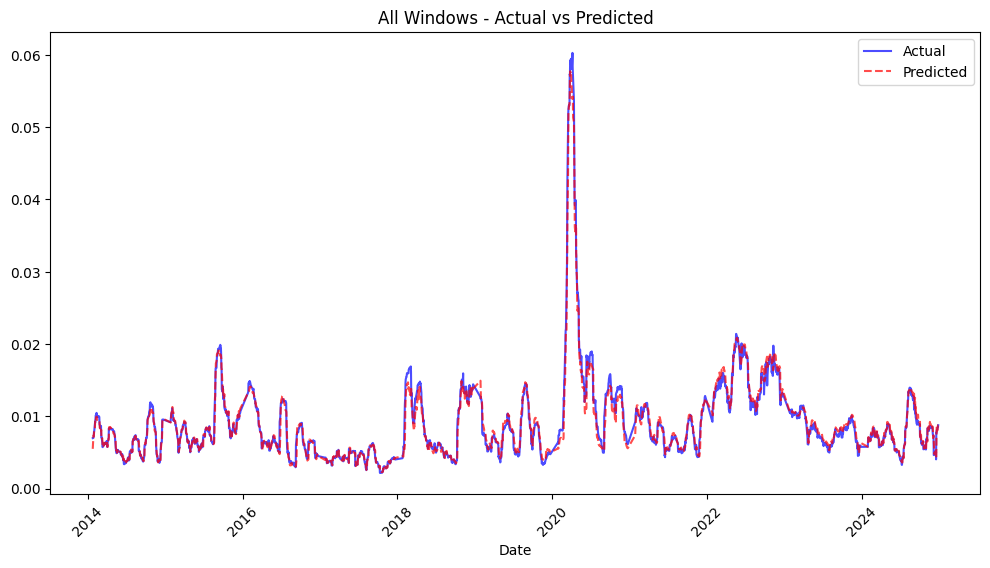

In [26]:
# Merge data across all windows
all_dates = np.concatenate([window_data["date_index"] for window_data in predictions])
all_actual = np.concatenate([window_data["actual"] for window_data in predictions])
all_predicted = np.concatenate([window_data["predictions"] for window_data in predictions])

plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label="Actual", color="blue", alpha=0.7)
plt.plot(all_dates, all_predicted, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
plt.title("All Windows - Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [27]:
# Save predictions to CSV
all_data = []
for window_data in predictions:
    df_window = pd.DataFrame({
        "Date": window_data["date_index"],
        "Actual": window_data["actual"],
        "Predicted": window_data["predictions"]
    })
    all_data.append(df_window)

# Combine all windows into a single DataFrame
df_predictions = pd.concat(all_data, ignore_index=True)  # Added ignore_index=True for clean row numbering

# Save to CSV
df_predictions.to_csv("3dense.csv", index=False)

print("Predictions successfully saved to 2dense.csv!")
print(f"First few rows of saved data:")
print(df_predictions.head())


Predictions successfully saved to 2dense.csv!
First few rows of saved data:
        Date    Actual  Predicted
0 2014-01-24  0.006968   0.005490
1 2014-01-27  0.006996   0.007126
2 2014-01-28  0.007142   0.007363
3 2014-01-29  0.007384   0.007283
4 2014-01-30  0.007886   0.007617
